# Using insulation boundaries to generate TAD windows

***Purpose:*** Extracting genomic intervals as TAD regions from insulation boundaries.

Including some checks:
* histograms to visualize TAD window sizes extracted from Bonev 2017 boundaries
* Checking for genes that fall within vs. outside of these boundaries
* Additionally, tested impact of two different methods of defining TAD windows: windows_from_boundaries(take_midpoint=True / False)

In [1]:
import sys
 
# setting path
sys.path.append('../../transcription_data_analysis')

import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Generating TADs

* First, take_midpoint = False -- generates TAD regions to be the intervals **between** insulation boundaries (i.e. has gaps)

* take_midpoint = True generates TAD regions separated by midpoint of boundary file

### Load Hi-C data

Process insulation boundaries to represent TADs as genomic intervals

In [3]:
# load features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

# tad df without mid-point -- 
tad_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=False)

### What are TAD window sizes

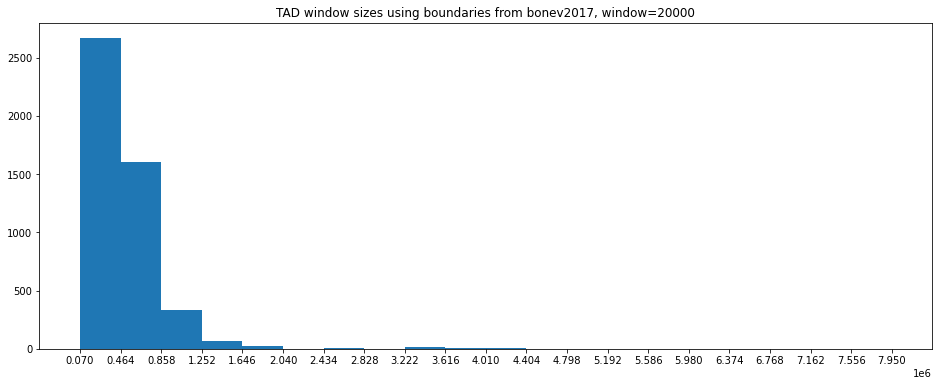

In [4]:
tad_sizes = tad_df['end'] - tad_df['start']
fig = plt.figure(figsize=(16,6))
n, bins, bars = plt.hist(tad_sizes.values, bins=20)

plt.xticks(bins.astype(np.double))
plt.title('TAD window sizes using boundaries from bonev2017, window=20000')
plt.show()

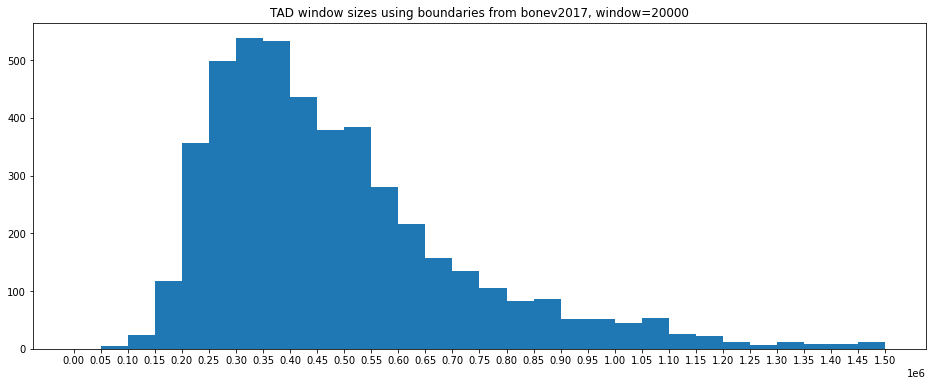

In [5]:
tad_sizes = tad_df['end'] - tad_df['start']
fig = plt.figure(figsize=(16,6))
n, bins, bars = plt.hist(tad_sizes.values, range=(0, 1.5e6), bins=30)

plt.xticks(bins.astype(np.double))
plt.title('TAD window sizes using boundaries from bonev2017, window=20000')
plt.show()

## Other Explorations:

### Histogram to measure distribution of types of genes within each TAD?
   * Note: Not super informative --> there are less total DE genes, so it makes sense that they exist in lower numbers within TADs

In [7]:
# import gene data
day1_res_df = flt.load_tss_df(cutoff=None)
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


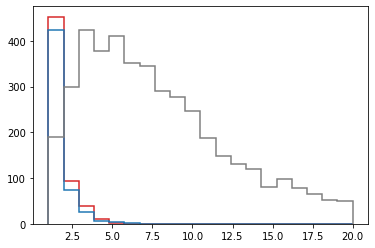

In [8]:
# This is plotting number of genes within each TAD window --> not yet categorized / labeled by number of enhancers within each TAD window
ax = plt.subplot()
agg_key='DE_status'
category_colors={"up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}
val_range=(1,20)
bins=20

df = day1_res_df.copy()
for cat, col in category_colors.items():

    cat_ix = np.where(df[agg_key] == cat)

    counts = bf.count_overlaps(tad_df, df.iloc[cat_ix])['count']

    ax.hist(counts,
            bins=bins,
            range=val_range,
            density=False,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)


### How many up/down/non-reg genes fell in-between TADs?

Interpret as: how many TSSes are **within** the insulation boundaries, instead of between --> do these get skipped?

In [9]:
# Using the tad windows to re-create the insulation_boundary windows by performing inverse operation
chrom_sizes = flt.extract_chrom_sizes_from_insulation(insulation_table)
insulation_windows = flt.windows_from_boundaries(tad_df, chrom_sizes)

up genes: 34 total have their promoter within an insulation window.
down genes: 29 total have their promoter within an insulation window.
nonsig genes: 1743 total have their promoter within an insulation window.


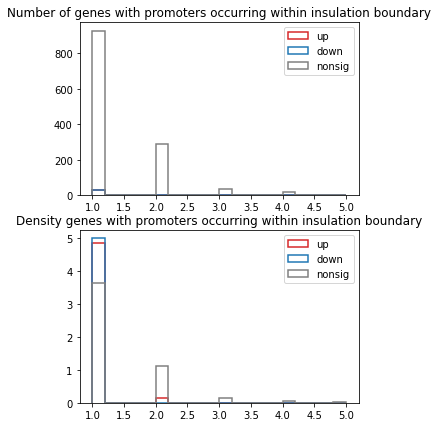

In [10]:
fig, (ax1, ax2)= plt.subplots(2, 1, figsize=(5, 7))
agg_key='DE_status'
category_colors={"up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}
val_range=(1,5)
bins=20

df = day1_res_df.copy()
for cat, col in category_colors.items():

    cat_ix = np.where(df[agg_key] == cat)

    counts = bf.count_overlaps(insulation_windows, df.iloc[cat_ix])['count']
    print('{} genes: {} total have their promoter within an insulation window.'.
          format(cat, counts.sum()))

    ax1.hist(counts,
            bins=bins,
            range=val_range,
            density=False,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)
    ax1.set_title('Number of genes with promoters occurring within insulation boundary')
    ax1.legend()
    
    ax2.hist(counts,
            bins=bins,
            range=val_range,
            density=True,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)
    ax2.set_title('Density genes with promoters occurring within insulation boundary')
    ax2.legend()

### Conclusions: We do have some genes with TSSes occuring along the insulation boundary

- There are some small number of down-regulat
- generating windows by mid-point may generate ~slightly different results